# <center> Bike Rental Data Management

## Library and Data Import

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import datetime
import string
import sqlalchemy

files = glob.glob('bike-rental-starter-kit/data/JC-2016*-citibike-tripdata.csv')

df_bike = pd.DataFrame()

df_list = []
for file in files:
    data = pd.read_csv(file)
    df_list.append(data)

if df_list:  # Check if df_list is not empty
    df_bike = pd.concat(df_list)
else:
    print("No files matched the pattern.")

# Reset the index after concatenation
df_bike.reset_index(drop=True, inplace=True)
# Add an id column to the dataframe
df_bike['id'] = df_bike.index

## Citi Bike Data Overview

Inspect the beginning and the end of the data set:

In [51]:
print(df_bike.head(3))

   Trip Duration           Start Time            Stop Time  Start Station ID  \
0            362  2016-01-01 00:02:52  2016-01-01 00:08:54              3186   
1            200  2016-01-01 00:18:22  2016-01-01 00:21:42              3186   
2            202  2016-01-01 00:18:25  2016-01-01 00:21:47              3186   

  Start Station Name  Start Station Latitude  Start Station Longitude  \
0      Grove St PATH               40.719586               -74.043117   
1      Grove St PATH               40.719586               -74.043117   
2      Grove St PATH               40.719586               -74.043117   

   End Station ID End Station Name  End Station Latitude  \
0            3209     Brunswick St             40.724176   
1            3213   Van Vorst Park             40.718489   
2            3213   Van Vorst Park             40.718489   

   End Station Longitude  Bike ID   User Type  Birth Year  Gender  id  
0             -74.050656    24647  Subscriber      1964.0       2   0  
1

In [52]:
print(df_bike.tail(3))

        Trip Duration           Start Time            Stop Time  \
247581            173  2016-12-31 23:44:37  2016-12-31 23:47:31   
247582           2424  2016-12-31 23:44:50  2017-01-01 00:25:14   
247583           2419  2016-12-31 23:44:50  2017-01-01 00:25:10   

        Start Station ID Start Station Name  Start Station Latitude  \
247581              3186      Grove St PATH               40.719586   
247582              3214   Essex Light Rail               40.712774   
247583              3214   Essex Light Rail               40.712774   

        Start Station Longitude  End Station ID  End Station Name  \
247581               -74.043117            3270   Jersey & 6th St   
247582               -74.036486            3214  Essex Light Rail   
247583               -74.036486            3214  Essex Light Rail   

        End Station Latitude  End Station Longitude  Bike ID   User Type  \
247581             40.725289             -74.045572    24641  Subscriber   
247582           

&rarr; Some initial observations:
- There are about 250k records
- Checking the data dictionary:
  - `Trip Duration` is in seconds
  - `Gender` can be `0=unknown`, `1=male`, and `2=female`
  - `User Type` has values `Customer=24 hour pass or 3 day user` and `Subscriber=Annual Member`

In [53]:
df_bike.describe()

,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Gender,id
count,2.475840e+05,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,247584.000000,228585.000000,247584.000000,247584.000000
mean,8.856305e+02,3207.065206,40.723121,-74.046438,3203.572553,40.722594,-74.045855,24935.260481,1979.335276,1.123534,123791.500000
std,3.593798e+04,26.955103,0.008199,0.011211,61.579494,0.007958,0.011283,748.469712,9.596809,0.518687,71471.488861
min,6.100000e+01,3183.000000,40.692640,-74.096937,147.000000,40.692216,-74.096937,14552.000000,1900.000000,0.000000,0.000000
25%,2.480000e+02,3186.000000,40.717732,-74.050656,3186.000000,40.716540,-74.050444,24491.000000,1974.000000,1.000000,61895.750000
50%,3.900000e+02,3201.000000,40.721525,-74.044247,3199.000000,40.721124,-74.043117,24609.000000,1981.000000,1.000000,123791.500000
75%,6.660000e+02,3211.000000,40.727596,-74.038051,3211.000000,40.727224,-74.036486,24719.000000,1986.000000,1.000000,185687.250000
max,1.632981e+07,3426.000000,40.752559,-74.032108,3426.000000,40.801343,-73.957390,27274.000000,2000.000000,2.000000,247583.000000


A couple observations:
- `Trip Duration` jumps five orders of magnitude from the 75th percentile to the maximum
- `Birth Year` has a minimum value of 1900, which would correspond to an age of 125
- `Birth Year` might be missing some values

Checking for missing values:

In [54]:
df_bike.isna().sum()

Trip Duration                  0
Start Time                     0
Stop Time                      0
Start Station ID               0
Start Station Name             0
Start Station Latitude         0
Start Station Longitude        0
End Station ID                 0
End Station Name               0
End Station Latitude           0
End Station Longitude          0
Bike ID                        0
User Type                    380
Birth Year                 18999
Gender                         0
id                             0
dtype: int64

Checking for duplicated values:

In [55]:
df_bike.duplicated().sum()

np.int64(0)

We'll need to investigate both `User Type` and `Birth Year` to see what data is missing. We'll also want to look into `Gender` -- there's no missing data, but we know from the dictionary that `0` corresponds to `Unknown`.

For now, let's finish initial exploration by checking data types. It looks like `Start Time` and `Stop Time` need to be datetimes, which we can fix now. Other incorrect data types, like `Birth Year`, will have to wait until we look at `NaNs`.

In [56]:
df_bike.dtypes

Trip Duration                int64
Start Time                  object
Stop Time                   object
Start Station ID             int64
Start Station Name          object
Start Station Latitude     float64
Start Station Longitude    float64
End Station ID               int64
End Station Name            object
End Station Latitude       float64
End Station Longitude      float64
Bike ID                      int64
User Type                   object
Birth Year                 float64
Gender                       int64
id                           int64
dtype: object

Casting `Start Time` and `Stop Time` as datetimes

In [57]:
df_bike['Start Time'] = pd.to_datetime(df_bike['Start Time'], format='%Y-%m-%d %H:%M:%S')
df_bike['Stop Time'] = pd.to_datetime(df_bike['Stop Time'], format='%Y-%m-%d %H:%M:%S')
df_bike.dtypes

Trip Duration                       int64
Start Time                 datetime64[ns]
Stop Time                  datetime64[ns]
Start Station ID                    int64
Start Station Name                 object
Start Station Latitude            float64
Start Station Longitude           float64
End Station ID                      int64
End Station Name                   object
End Station Latitude              float64
End Station Longitude             float64
Bike ID                             int64
User Type                          object
Birth Year                        float64
Gender                              int64
id                                  int64
dtype: object

## Cleaning and Transforming Citibike Data

Columns needed to investigate:
- Birth Year (suspiciously small minimum, missing data)
- User Type (missing data)
- Trip Duration (suspiciously large maximum)
- Gender (The unknown type)

Firsly, remove spaces and uppercase letters from the column names

In [58]:
df_bike.columns = [x.replace (' ', '_').lower() for x in df_bike.columns] 

### `birth_year` column

Calculate an approximate age and investigate the large outlier

In [59]:
df_bike['age'] = 2025 - df_bike['birth_year']
df_bike.age.sort_values(ascending=False).head(5)

215055    125.0
136211     91.0
180373     88.0
213567     88.0
187190     88.0
Name: age, dtype: float64

It appears that there is only one outlier out of 125. We will eliminate that from the dataset because it will change the results of statistical analyses and we are not expecting any riders of that age.

In [60]:
df_bike.drop([215055], inplace=True)

Investigate the missing data in `birth_year`

In [61]:
missing_age = df_bike[df_bike[['age']].isnull().any(axis=1)]
missing_age.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,age
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,0,4,NaN
5,883,2016-01-01 01:03:28,2016-01-01 01:18:11,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24442,Customer,NaN,0,5,NaN
22,988,2016-01-01 03:16:33,2016-01-01 03:33:02,3196,Riverview Park,40.744319,-74.043991,3209,Brunswick St,40.724176,-74.050656,24662,Customer,NaN,0,22,NaN
53,3090,2016-01-01 11:07:15,2016-01-01 11:58:46,3203,Hamilton Park,40.727596,-74.044247,3203,Hamilton Park,40.727596,-74.044247,24444,Customer,NaN,0,53,NaN
57,788,2016-01-01 11:50:30,2016-01-01 12:03:39,3210,Pershing Field,40.742677,-74.051789,3195,Sip Ave,40.730743,-74.063784,24573,Customer,NaN,0,57,NaN


A couple observations:
- The first five are all customers
- The first five all have unknown gender

Let's check if that pattern holds up:


In [62]:
missing_age['user_type'].value_counts(dropna=False)

user_type
Customer      15470
Subscriber     3529
Name: count, dtype: int64

In [63]:
missing_age['gender'].value_counts(dropna=False)

gender
0    18999
Name: count, dtype: int64

In [64]:
df_bike['user_type'].value_counts(dropna=False)

user_type
Subscriber    231682
Customer       15521
NaN              380
Name: count, dtype: int64

Observations:
- all records with missing `birth_year` also have `unknown` gender
- the customer `user_type` seems to be missing a lot of `birth_year` data because there are 15521 records of customers in `user_type` of the data

Let's check the percentages for `user_type`:

In [65]:
missing_age['user_type'].value_counts() / df_bike['user_type'].value_counts()

user_type
Customer      0.996714
Subscriber    0.015232
Name: count, dtype: float64

Observations:
- 99% of customers are missing `birth_year`
- 1.5% of subscribers are missing `birth_year`
All records with missing `birth_year` also have unknown `gender`, which likely also corresponds to the customer `user_type`
We won't delete records that are missing `birth_year`, since that would remove all customers. We'll have to keep this missing data in mind when developing the database.

### `user_type` column

There are `380` missing records, less than 1% of total. We should check if these records are also missing birth_year or have `unknown` gender:

In [66]:
missing_user_type = df_bike[df_bike[['user_type']].isnull().any(axis=1)]
((missing_user_type['gender'] == 0) | (missing_user_type[['birth_year']].isnull().any(axis=1))).sum()

np.int64(0)

Given this result, these are most likely subscribers, but it is possible they are customers. Let's take a look at the missing data over the course of the year:

In [67]:
missing_user_type.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,age
25267,156,2016-03-23 09:08:34,2016-03-23 09:11:11,3214,Essex Light Rail,40.712774,-74.036486,3183,Exchange Place,40.716247,-74.033459,24444,NaN,1987.0,1,25267,38.0
25668,164,2016-03-23 22:17:45,2016-03-23 22:20:29,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,24675,NaN,1987.0,1,25668,38.0
25894,171,2016-03-24 11:46:39,2016-03-24 11:49:31,3214,Essex Light Rail,40.712774,-74.036486,3183,Exchange Place,40.716247,-74.033459,24697,NaN,1987.0,1,25894,38.0
26189,204,2016-03-24 20:45:45,2016-03-24 20:49:10,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,24387,NaN,1987.0,1,26189,38.0
26630,380,2016-03-25 19:15:56,2016-03-25 19:22:17,3183,Exchange Place,40.716247,-74.033459,3184,Paulus Hook,40.714145,-74.033552,24412,NaN,1987.0,1,26630,38.0


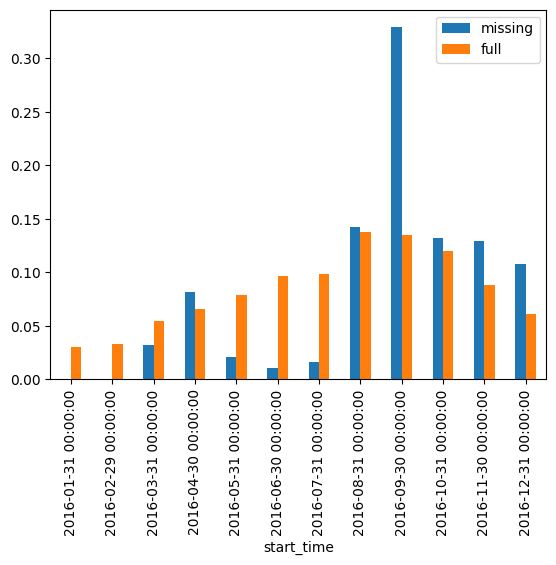

In [68]:
my = (missing_user_type.resample('ME',on='start_time').count()['id']/len(missing_user_type)).rename('missing')
dy = (df_bike.resample('ME',on='start_time').count()['id']/len(df_bike)).rename('full')
combo = pd.concat([my,dy],axis=1)


ax = combo.plot.bar()

While the missing data is a small percentage of the total, an eye test of the distributions indicates that it might not be missing at random. From a data management perspective, let's keep the data but replace the NaN with an `unknown` category. This way, the analytics team can investigate further and we can keep track of this issue if we update the database with more years of data.

In [69]:
df_bike.fillna({'user_type': 'Unknown'}, inplace=True)

In [70]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247583 entries, 0 to 247583
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   trip_duration            247583 non-null  int64         
 1   start_time               247583 non-null  datetime64[ns]
 2   stop_time                247583 non-null  datetime64[ns]
 3   start_station_id         247583 non-null  int64         
 4   start_station_name       247583 non-null  object        
 5   start_station_latitude   247583 non-null  float64       
 6   start_station_longitude  247583 non-null  float64       
 7   end_station_id           247583 non-null  int64         
 8   end_station_name         247583 non-null  object        
 9   end_station_latitude     247583 non-null  float64       
 10  end_station_longitude    247583 non-null  float64       
 11  bike_id                  247583 non-null  int64         
 12  user_type            

### `gender` column

Let's confirm that most `unknown` genders correspond to `user_type = Customer`

In [71]:
df_bike.groupby(['user_type', 'gender']).count()['id']

user_type   gender
Customer    0          15470
            1             36
            2             15
Subscriber  0           4431
            1         176898
            2          50353
Unknown     1            262
            2            118
Name: id, dtype: int64

We won't delete these rows (to avoid removing almost all customers) but as with `birth_year` we'll need to be aware that demographic information is only really useful for `user_type = subscriber`.

`trip_duration` column

This column had a suspiciously large maximum. Let's investigate:

In [72]:
df_bike['trip_minutes'] = round(df_bike['trip_duration'] / 60, 2)
df_bike['trip_hours'] = round(df_bike['trip_duration'] / 3600, 2)
df_bike[['trip_duration', 'trip_minutes', 'trip_hours']].describe()

,trip_duration,trip_minutes,trip_hours
count,2.475830e+05,247583.000000,247583.000000
mean,8.856300e+02,14.760494,0.246006
std,3.593805e+04,598.967493,9.982797
min,6.100000e+01,1.020000,0.020000
25%,2.480000e+02,4.130000,0.070000
50%,3.900000e+02,6.500000,0.110000
75%,6.660000e+02,11.100000,0.180000
max,1.632981e+07,272163.470000,4536.060000


Observations:
- minimum trip length = 61 seconds
- maximum trip = 4,536 hours = 189 days
  
According to the data dictionary, trips under 60 seconds were already assumed to be false starts/stops and were pruned.

For the max, Citi Bike policies state that the maximum length of a trip is 24 hours (or 86400 seconds).

We won't delete the longer trips, since it is possible these correspond to bike docking issues or users breaking the rules (which analysts might want to investigate). However, we will add a flag so that the analytics team can easily filter these out if desired.

In [73]:
# create a column to flag rides that do not comply with system rules
df_bike['valid_duration'] = df_bike['trip_duration'].apply(lambda x: 0 if x > 86400 else 1).astype(bool)

Since we've dropped some data, let's reset our index and `id` columns

In [74]:
df_bike.reset_index(drop=True,inplace=True)
df_bike['id'] = df_bike.index
df_bike.tail()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,id,age,trip_minutes,trip_hours,valid_duration
247578,557,2016-12-31 23:10:16,2016-12-31 23:19:33,3214,Essex Light Rail,40.712774,-74.036486,3203,Hamilton Park,40.727596,-74.044247,24465,Subscriber,1981.0,2,247578,44.0,9.28,0.15,True
247579,2749,2016-12-31 23:29:39,2017-01-01 00:15:29,3183,Exchange Place,40.716247,-74.033459,3183,Exchange Place,40.716247,-74.033459,24389,Customer,NaN,0,247579,NaN,45.82,0.76,True
247580,173,2016-12-31 23:44:37,2016-12-31 23:47:31,3186,Grove St PATH,40.719586,-74.043117,3270,Jersey & 6th St,40.725289,-74.045572,24641,Subscriber,1978.0,1,247580,47.0,2.88,0.05,True
247581,2424,2016-12-31 23:44:50,2017-01-01 00:25:14,3214,Essex Light Rail,40.712774,-74.036486,3214,Essex Light Rail,40.712774,-74.036486,26219,Subscriber,1960.0,2,247581,65.0,40.40,0.67,True
247582,2419,2016-12-31 23:44:50,2017-01-01 00:25:10,3214,Essex Light Rail,40.712774,-74.036486,3214,Essex Light Rail,40.712774,-74.036486,24471,Subscriber,1956.0,1,247582,69.0,40.32,0.67,True


## Weather Data Overview

Import weather data

In [75]:
df_weather = pd.read_csv('bike-rental-starter-kit/data/newark_airport_2016.csv')
df_weather.head()

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5
0,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-01,12.75,NaN,0.0,0.0,0.0,41,43,34,NaN,270,280.0,25.9,35.1
1,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-02,9.40,NaN,0.0,0.0,0.0,36,42,30,NaN,260,260.0,21.0,25.1
2,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-03,10.29,NaN,0.0,0.0,0.0,37,47,28,NaN,270,250.0,23.9,30.0
3,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-04,17.22,NaN,0.0,0.0,0.0,32,35,14,NaN,330,330.0,25.9,33.1
4,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-05,9.84,NaN,0.0,0.0,0.0,19,31,10,NaN,360,350.0,25.1,31.1


In [76]:
df_weather.describe()

,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5
count,366.000000,0.0,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,0.0,366.000000,364.000000,366.000000,364.000000
mean,9.429973,NaN,0.104945,0.098087,0.342623,57.196721,65.991803,48.459016,NaN,217.841530,228.269231,20.484426,26.801648
std,3.748174,NaN,0.307496,1.276498,2.078510,17.466981,18.606301,17.135790,NaN,102.548282,97.415777,6.848390,8.882610
min,2.460000,NaN,0.000000,0.000000,0.000000,8.000000,18.000000,0.000000,NaN,10.000000,10.000000,6.900000,10.100000
25%,6.765000,NaN,0.000000,0.000000,0.000000,43.000000,51.250000,35.000000,NaN,150.000000,150.000000,15.000000,19.900000
50%,8.720000,NaN,0.000000,0.000000,0.000000,56.000000,66.000000,47.000000,NaN,240.000000,260.000000,19.900000,25.100000
75%,11.410000,NaN,0.030000,0.000000,0.000000,74.000000,83.000000,64.000000,NaN,300.000000,300.000000,23.900000,31.100000
max,22.820000,NaN,2.790000,24.000000,20.100000,89.000000,99.000000,80.000000,NaN,360.000000,360.000000,48.100000,66.000000


## Cleaning and Transforming Weather Data

PGTM (peak gust time) and TSUN (total minutes of sun) are entirely missing and will be dropped. WDFx and WSFx refer to the fastest x-minute wind, and are difficult to connect directly to our data (since we don't know when that speed occurred.) We'll therefore stick with AWND (average wind speed) for our wind-speed variable.

Also, since all our data is from the same station, we'll drop those details for now.

In [77]:
df_weather.drop(['STATION','NAME','PGTM','TSUN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'],axis=1, inplace=True)

Fix data type issues

In [78]:
df_weather.dtypes

DATE     object
AWND    float64
PRCP    float64
SNOW    float64
SNWD    float64
TAVG      int64
TMAX      int64
TMIN      int64
dtype: object

In [79]:
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], format='%Y-%m-%d')

In [80]:
df_weather.dtypes

DATE    datetime64[ns]
AWND           float64
PRCP           float64
SNOW           float64
SNWD           float64
TAVG             int64
TMAX             int64
TMIN             int64
dtype: object

Let's take a look at the numeric variables:

In [81]:
df_weather.describe()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
count,366,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2016-07-01 12:00:00,9.429973,0.104945,0.098087,0.342623,57.196721,65.991803,48.459016
min,2016-01-01 00:00:00,2.460000,0.000000,0.000000,0.000000,8.000000,18.000000,0.000000
25%,2016-04-01 06:00:00,6.765000,0.000000,0.000000,0.000000,43.000000,51.250000,35.000000
50%,2016-07-01 12:00:00,8.720000,0.000000,0.000000,0.000000,56.000000,66.000000,47.000000
75%,2016-09-30 18:00:00,11.410000,0.030000,0.000000,0.000000,74.000000,83.000000,64.000000
max,2016-12-31 00:00:00,22.820000,2.790000,24.000000,20.100000,89.000000,99.000000,80.000000
std,NaN,3.748174,0.307496,1.276498,2.078510,17.466981,18.606301,17.135790


No obvious issues with outliers (temperatures are Fahrenheit and precipitation/snow amounts in inches).

Checking for null values:

In [82]:
df_weather.isnull().sum()

DATE    0
AWND    0
PRCP    0
SNOW    0
SNWD    0
TAVG    0
TMAX    0
TMIN    0
dtype: int64

Rename the columns to delete the uppercase and space:

In [83]:
df_weather.columns = ['rec_date','avg_wind','prcp','snow_amt','snow_depth','tavg','tmax','tmin']

Add some new columns to support analysts

In [84]:
df_weather['rain'] = df_weather['prcp'].apply(lambda x: 1 if x > 0 else 0).astype(bool)
df_weather['snow'] = df_weather['snow_amt'].apply(lambda x: 1 if x > 0 else 0).astype(bool)

In [85]:
df_weather.head()

,rec_date,avg_wind,prcp,snow_amt,snow_depth,tavg,tmax,tmin,rain,snow
0,2016-01-01,12.75,0.0,0.0,0.0,41,43,34,False,False
1,2016-01-02,9.40,0.0,0.0,0.0,36,42,30,False,False
2,2016-01-03,10.29,0.0,0.0,0.0,37,47,28,False,False
3,2016-01-04,17.22,0.0,0.0,0.0,32,35,14,False,False
4,2016-01-05,9.84,0.0,0.0,0.0,19,31,10,False,False


## Postgres Table

### Date Dimension Table

Since our use-case depends heavily on dates, it makes sense to create a dedicated date dimension table to simplify queries. Let's create one that has date, month name, day name, financial quarter, and weekend information.

In [86]:
# our data starts on 1/1/2016
start = datetime.datetime(2016, 1, 1)
date_col = [start + datetime.timedelta(days=x) for x in range(0, 366)]
df_date = pd.DataFrame(date_col, dtype='datetime64[ns]')
df_date.columns = ['full_date']
df_date.head()

,full_date
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05


In [87]:
# generate months day names
df_date['month'] = df_date['full_date'].apply(lambda x: x.month)
df_date['day'] = df_date['full_date'].apply(lambda x: x.day)
df_date['month_name'] = df_date['full_date'].apply(lambda x: x.strftime('%B'))
df_date['day_name'] = df_date['full_date'].apply(lambda x: x.strftime('%A'))
df_date['weekend'] = df_date['day_name'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0).astype(bool)
df_date.head()

,full_date,month,day,month_name,day_name,weekend
0,2016-01-01,1,1,January,Friday,False
1,2016-01-02,1,2,January,Saturday,True
2,2016-01-03,1,3,January,Sunday,True
3,2016-01-04,1,4,January,Monday,False
4,2016-01-05,1,5,January,Tuesday,False


In [88]:
# generate financial quarter
def get_quarter(month):
    if month in [1, 2, 3]:
        return 1
    elif month in [4, 5, 6]:
        return 2
    elif month in [7, 8, 9]:
        return 3
    else:
        return 4

df_date['financial_qtr'] = df_date['month'].apply(get_quarter)
df_date.head()


,full_date,month,day,month_name,day_name,weekend,financial_qtr
0,2016-01-01,1,1,January,Friday,False,1
1,2016-01-02,1,2,January,Saturday,True,1
2,2016-01-03,1,3,January,Sunday,True,1
3,2016-01-04,1,4,January,Monday,False,1
4,2016-01-05,1,5,January,Tuesday,False,1


We'll want to use this date dimension table in joins, but joining on date-time columns is risky. Let's add a date key to each of our tables.

In [89]:
df_date['date_key'] = df_date['full_date'].apply(lambda x: int(x.strftime('%Y%m%d').strip('-')))
df_weather['date_key'] = df_weather['rec_date'].apply(lambda x: int(x.strftime('%Y%m%d').strip('-')))
df_bike['date_key'] = df_bike['start_time'].apply(lambda x: int(x.strftime('%Y%m%d').strip('-')))

# take a look at the head and tail of the date table
df_date.head()

,full_date,month,day,month_name,day_name,weekend,financial_qtr,date_key
0,2016-01-01,1,1,January,Friday,False,1,20160101
1,2016-01-02,1,2,January,Saturday,True,1,20160102
2,2016-01-03,1,3,January,Sunday,True,1,20160103
3,2016-01-04,1,4,January,Monday,False,1,20160104
4,2016-01-05,1,5,January,Tuesday,False,1,20160105


In [90]:
df_date.tail()

,full_date,month,day,month_name,day_name,weekend,financial_qtr,date_key
361,2016-12-27,12,27,December,Tuesday,False,4,20161227
362,2016-12-28,12,28,December,Wednesday,False,4,20161228
363,2016-12-29,12,29,December,Thursday,False,4,20161229
364,2016-12-30,12,30,December,Friday,False,4,20161230
365,2016-12-31,12,31,December,Saturday,True,4,20161231


In [91]:
df_date.dtypes

full_date        datetime64[ns]
month                     int64
day                       int64
month_name               object
day_name                 object
weekend                    bool
financial_qtr             int64
date_key                  int64
dtype: object

## Demographics

In [92]:
# create a demographics table with all the unique demographics in the original dataset
trip_demo = df_bike[['user_type','birth_year','gender','age']].drop_duplicates(subset=['user_type','birth_year','gender']).reset_index(drop=True)
trip_demo['trip_demo'] = trip_demo.index

# add the trip_demo key to a rides table
rides = df_bike.merge(trip_demo, on=['user_type','birth_year','gender','age']).sort_values(by='id').reset_index(drop=True)

# drop the demographic info from rides
rides = rides.drop(['user_type','birth_year','gender','age'],axis=1)

rides.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,id,trip_minutes,trip_hours,valid_duration,date_key,trip_demo
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,0,6.03,0.10,True,20160101,0
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,1,3.33,0.06,True,20160101,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,2,3.37,0.06,True,20160101,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,3,4.13,0.07,True,20160101,3
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,4,15.05,0.25,True,20160101,4


Because we've created a new key, let's double check that merging with the demographics table reproduces the original dataframe.

In [93]:
# first merge the two tables and
# - sort by ID to match df_bike's sorting
# - reset the index to match df_bike's index
# - drop the trip_demo join key
ridesmerge = rides.merge(trip_demo,on='trip_demo').sort_values(by='id').reset_index(drop=True).drop('trip_demo',axis=1)

# count the number of positions where ridesmerge is different from df_bike
# note that NaN != NaN, so we also need to make sure at least one isn't NaN
(df_bike.ne(ridesmerge) & (df_bike.notna() | ridesmerge.notna())).sum()

age                        0
bike_id                    0
birth_year                 0
date_key                   0
end_station_id             0
end_station_latitude       0
end_station_longitude      0
end_station_name           0
gender                     0
id                         0
start_station_id           0
start_station_latitude     0
start_station_longitude    0
start_station_name         0
start_time                 0
stop_time                  0
trip_duration              0
trip_hours                 0
trip_minutes               0
user_type                  0
valid_duration             0
dtype: int64

In [94]:
# change the name of the trip_demo id column for the database
trip_demo.rename(columns={'trip_demo':'id'}, inplace=True)
trip_demo.head()

,user_type,birth_year,gender,age,id
0,Subscriber,1964.0,2,61.0,0
1,Subscriber,1962.0,1,63.0,1
2,Subscriber,1962.0,2,63.0,2
3,Subscriber,1984.0,1,41.0,3
4,Customer,NaN,0,NaN,4


## Station Table

Let's create a table of stations. These already have IDs, so we just need to create a new table with station id, name, latitude, and longitude. The easiest way to make sure we have all the necessary records is simply to make a table of all possible station records and drop duplicates.

In [95]:
# create tables of start stations and end stations
starts = rides[['start_station_id','start_station_name','start_station_latitude','start_station_longitude']]
ends = rides[['end_station_id','end_station_name','end_station_latitude','end_station_longitude']]

# rename so both start and end dataframes have the same column names
starts.columns = ['id','station_name','latitude','longitude']
ends.columns = ['id','station_name','latitude','longitude']

# concatenate and drop duplicates
stations = pd.concat([starts,ends]).drop_duplicates()

# drop station names and locations from rides
rides = rides.drop(['start_station_name','start_station_latitude','start_station_longitude','end_station_name','end_station_latitude','end_station_longitude'],axis=1)

rides.head()

,trip_duration,start_time,stop_time,start_station_id,end_station_id,bike_id,id,trip_minutes,trip_hours,valid_duration,date_key,trip_demo
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,3209,24647,0,6.03,0.10,True,20160101,0
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,3213,24605,1,3.33,0.06,True,20160101,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,3213,24689,2,3.37,0.06,True,20160101,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,3203,24693,3,4.13,0.07,True,20160101,3
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,3210,24573,4,15.05,0.25,True,20160101,4


In [96]:
stations.head()

,id,station_name,latitude,longitude
0,3186,Grove St PATH,40.719586,-74.043117
3,3209,Brunswick St,40.724176,-74.050656
4,3195,Sip Ave,40.730743,-74.063784
7,3211,Newark Ave,40.721525,-74.046305
8,3187,Warren St,40.721124,-74.038051


## Weather Table

In [97]:
df_weather.head()

,rec_date,avg_wind,prcp,snow_amt,snow_depth,tavg,tmax,tmin,rain,snow,date_key
0,2016-01-01,12.75,0.0,0.0,0.0,41,43,34,False,False,20160101
1,2016-01-02,9.40,0.0,0.0,0.0,36,42,30,False,False,20160102
2,2016-01-03,10.29,0.0,0.0,0.0,37,47,28,False,False,20160103
3,2016-01-04,17.22,0.0,0.0,0.0,32,35,14,False,False,20160104
4,2016-01-05,9.84,0.0,0.0,0.0,19,31,10,False,False,20160105


## Connect to the database using Sqlalchemy

In [98]:
DATABASE_TYPE = 'postgresql'
DBAPI = 'psycopg2'  # the appropriate DBAPI for your database
HOST = 'localhost' 
USER = 'postgres'
PASSWORD = 'yeunhaudi3006'
DATABASE = 'citibike'
PORT = 5432

# Create the connection string
connection_string = f"{DATABASE_TYPE}+{DBAPI}://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"

# Create the SQLAlchemy engine
engine = sqlalchemy.create_engine(connection_string)


con = engine.connect()
df_date.to_sql('date_dim', con, if_exists='append',index=False,chunksize=10000)
stations.to_sql('stations', con, if_exists='append',index=False,chunksize=10000)
trip_demo.to_sql('trip_demo', con, if_exists='append',index=False,chunksize=10000)
df_weather.to_sql('weather', con, if_exists='append',index=False,chunksize=10000)
rides.to_sql('rides', con, if_exists='append',index=False,chunksize=10000)

con.close()